In [7]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, calculate_bohmgyrbohm_particlediffusion, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter, get_chi_inter_unscaled, get_d_inter_unscaled, BCS, solve_time_evolution, calculate_bohmgrybohm_from_jardin, calculate_bohmdiffusion
from helpers import p_chi, r_chi, ode_system 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

from scipy.signal import find_peaks
from tqdm.notebook import tqdm 

In [13]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83627 # 83624 # 
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

""" Plotting of crash """
if shot_num == 83624:
    offset = 0.046
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83625:
    offset = 0.041
elif shot_num == 83627:
    offset = 0.043
else: 
    offset = 0.0


te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

N_POINTS    = 1000
R           = np.linspace(machineparams.Rmaj, machineparams.Rmaj + machineparams.Rmin, N_POINTS)
phi         = R**2
phi_norm    = (phi - phi.min()) / (phi.max() - phi.min())
pedestal_region =  phi_norm > 0.65
phi_norm    = phi_norm[pedestal_region]
phi         = phi[pedestal_region]
R           = R[pedestal_region]
dphi_normdr = 2*R / (phi.max() - phi.min())


steady_state_te = mtanh(phi_norm, te_fit_params.h1, te_fit_params.h0, te_fit_params.s, te_fit_params.w, te_fit_params.p)
steady_state_ne = mtanh(phi_norm, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, ne_fit_params.w, ne_fit_params.p)
steady_state_pe = mtanh(phi_norm, pe_fit_params.h1, pe_fit_params.h0, pe_fit_params.s, pe_fit_params.w, pe_fit_params.p)
# print(te_fit_params.h1, ne_fit_params.h1, pe_fit_params.h1)

# Finding ELM timings 
normed_tbeo = (pulse.tbeo.data - pulse.tbeo.data.mean() ) / pulse.tbeo.data.std()
delta_t = pulse.tbeo.time[1] - pulse.tbeo.time[0]
distance_between_elms = int(200E-6 / delta_t)*20
threshold_height = normed_tbeo.std()*2
peaks, _ = find_peaks(normed_tbeo, height=threshold_height, distance=distance_between_elms)
adjusted_peaks = np.empty_like(peaks)
# TODO: SHIFT THE TBEO SIGNAL BY SOME TIME 
for i, pk in enumerate(peaks): 
    for k in range(30): 
        if normed_tbeo[pk - k] < 0: 
            zero_crossing = pk-k 
            break 
        else: 
            zero_crossing = pk 
    adjusted_peaks[i] = zero_crossing


elm_times = pulse.tbeo.time[peaks]

elm_frequency = len(peaks) / (pulse.tbeo.time[-1] - pulse.tbeo.time[0])
t_minus_t_elm = np.empty(len(relevant_profiles.hrts_times))
for i, t in enumerate(relevant_profiles.hrts_times):
    nearest_elm_idx = np.argmin(np.abs(elm_times - t))
    t_nearest_elm = elm_times[nearest_elm_idx]    
    t_minus_t_elm[i] = t - t_nearest_elm

chi_gb, gyroradius = calculate_bohmgrybohm_from_jardin(R, phi, phi_norm, steady_state_te, machineparams)
Dbohm = calculate_bohmdiffusion(steady_state_te, machineparams)
Dbohmgb = calculate_bohmgyrbohm_particlediffusion(steady_state_te, machineparams)


In [14]:
# SETUP ELM CRASH 
CHI0_INTRA = chi_gb[0]    
D0_INTRA   = Dbohm[0]

C_CRASH =  1.4559 # scan_crashes[best_c_crash_idx] #  
intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_CRASH, CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_CRASH , D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INTRA_FLUXIN, 
        dphi_normdr=dphi_normdr,
        mps = machineparams
    )

intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
intra_params.te_inner_lim = 0.0

intra_params.particlefluxin = (Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = (intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]    
intra_params.ne_inner_lim = 0.0 # max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
intra_params.ne_outer_lim = 0.0 # steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3


tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)
solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)
solutions_intraelm_pe = calculate_pressure(solutions_intraelm_te, solutions_intraelm_ne)
post_elm_ne = solutions_intraelm_ne[:, -1]
post_elm_te = solutions_intraelm_te[:, -1]
post_elm_pe = solutions_intraelm_pe[:, -1]


In [4]:
# INTER-ELM GROWTH 
# We start with the post-ELM profiles as initial conditions 
# THe CHI then evolves in time, the edge diffusion grows (decays or gets lower) over time
# This is set by the C_INTER parameter, which to cause decay means to grow the value. 
# If we want C_INTER to be a tau_ELM timescale, i.e., inter-elm timescale, 
# Then we essentially go from CHI_0_INTER to CHI_F_INTER, where CHI_F_INTER is the steady state value

C_INTER_INITIAL = -0.05
C_INTER = 1.0
C_INTER_OVER_TIME = lambda t, cinter: C_INTER_INITIAL + (cinter + C_INTER_INITIAL)*t

CHI0_INTER = chi_gb[0]
D0_INTER   = Dbohm[0]


tau_interelm = 0.05 # 
tau_chistepping = 0.002
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 100)

initial_ne = post_elm_ne
initial_te = post_elm_te

collected_data = []
for tstep in tqdm(np.arange(0, tau_interelm, tau_chistepping)): 
    inter_params = TransParams(
        CHI=np.empty_like(phi_norm), # normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=np.empty_like(phi_norm), #normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=phi_norm**5, # np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_INTER_OVER_TIME(tstep, C_INTER),
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INTER_FLUXIN, 
        dphi_normdr=dphi_normdr,
        mps = machineparams
    )

    _t_interval = [tstep, tstep + tau_chistepping]
    _t_keep     = np.linspace(tstep, tstep + tau_chistepping, 10)

    inter_params.CHI = get_chi_inter(phi_norm, CHI0_INTER, steady_state_te, inter_params)
    inter_params.D = get_d_inter(phi_norm, D0_INTER, steady_state_ne, inter_params)

    inter_params.heatfluxin   = -(phi_norm[0]*(CHI0_INTER)*np.gradient(steady_state_te, phi_norm)[0])
    inter_params.te_inner_lim = max(steady_state_te) # 0.0

    inter_params.particlefluxin = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + inter_params.V[0]*steady_state_ne[0])
    inter_params.particlefluxout = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + inter_params.V[-1]*steady_state_ne[-1])
    inter_params.ne_inner_lim = max(steady_state_ne) 
    inter_params.ne_outer_lim = steady_state_ne[-1] 

    solutions_interelm_te = solve_pde(phi_norm, initial_te, _t_interval, inter_params, T_model, _t_keep)
    solutions_interelm_ne = solve_pde(phi_norm, initial_ne, _t_interval, inter_params, n_model, _t_keep)
    
    initial_te = solutions_interelm_te[:, -1]
    initial_ne = solutions_interelm_ne[:, -1]
    
    collect = (C_INTER, inter_params, solutions_interelm_ne, solutions_interelm_te, _t_keep)
    collected_data.append(collect)

  0%|          | 0/25 [00:00<?, ?it/s]

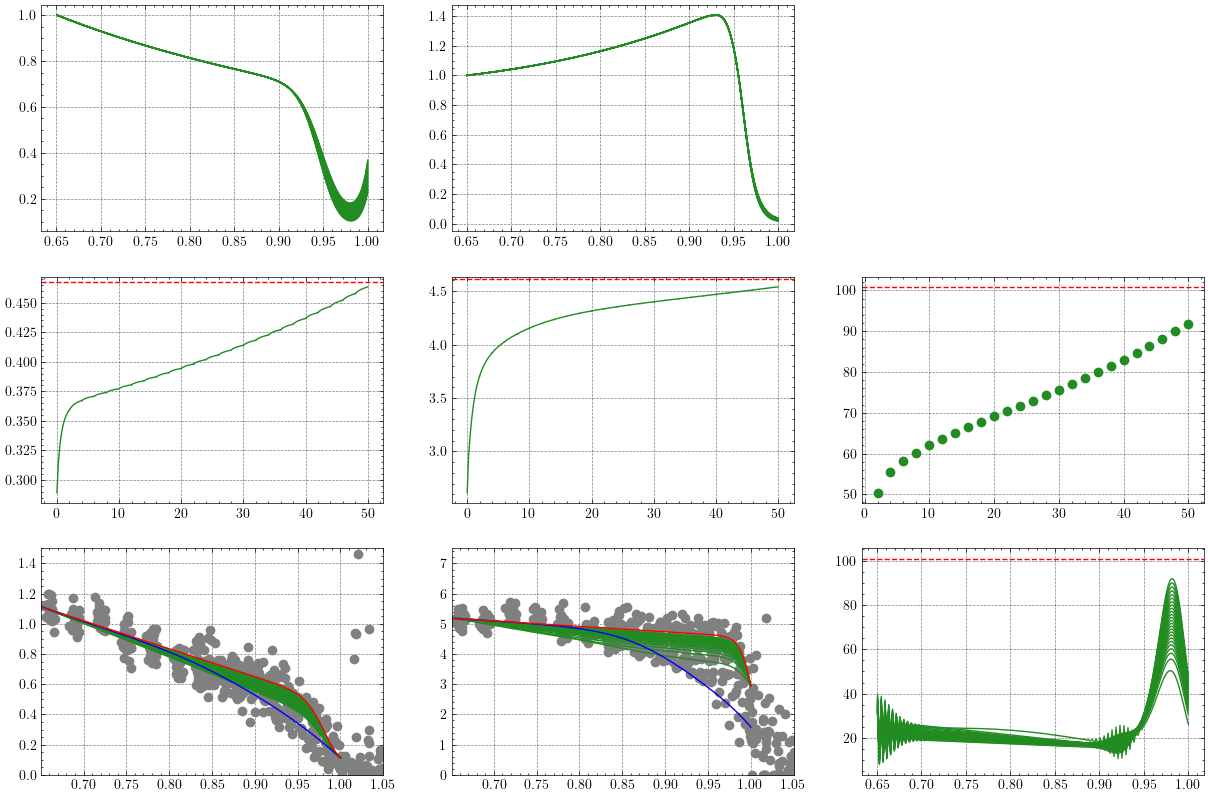

In [5]:
ped_idx_ne = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))
ped_idx_te = np.argmin(np.abs(phi_norm - (te_fit_params.p - te_fit_params.w / 2.0)))

fig, axs = plt.subplots(3,3, figsize=(15, 10))

for collect in collected_data: 
    C_INTER, inter_params, solutions_interelm_ne, solutions_interelm_te, _t_keep = collect
    color = 'forestgreen'
    axs[0,0].plot(phi_norm, inter_params.CHI / chi_gb[0], label=f"C_INTER={C_INTER}", color=color)
    axs[0,1].plot(phi_norm, inter_params.D / Dbohm[0], label=f"C_INTER={C_INTER}", color=color)

    axs[1, 0].plot(_t_keep*1000, solutions_interelm_te[ped_idx_te, :], label=f"C_INTER={C_INTER}", color=color)
    axs[1, 1].plot(_t_keep*1000, solutions_interelm_ne[ped_idx_ne, :], label=f"C_INTER={C_INTER}", color=color)

    axs[2, 0].plot(phi_norm, solutions_interelm_te[:, -1], label=f"C_INTER={C_INTER}", color=color)
    axs[2, 1].plot(phi_norm, solutions_interelm_ne[:, -1], label=f"C_INTER={C_INTER}", color=color)

    _pressure = calculate_pressure(solutions_interelm_te, solutions_interelm_ne)
    grad_pressure = abs(np.gradient(_pressure, phi_norm, axis=0))
    
    axs[1, 2].scatter(_t_keep[-1]*1000, np.max(grad_pressure[:, -1]), color=color)
    axs[2, 2].plot(phi_norm, grad_pressure[:, -1], color=color)


max_grad_p_steady_state = np.max(abs(np.gradient(steady_state_pe, phi_norm)))

axs[1, 2].axhline(max_grad_p_steady_state, color='red', linestyle='--', label='Steady state')
axs[2, 2].axhline(max_grad_p_steady_state, color='red', linestyle='--', label='Steady state')
axs[2, 0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, label='Experimental data', color='grey')
axs[2, 1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, label='Experimental data', color='grey')
axs[2, 0].plot(phi_norm, post_elm_te, label='Post-ELM', color='blue')
axs[2, 1].plot(phi_norm, post_elm_ne, label='Post-ELM', color='blue')
axs[2, 0].plot(phi_norm, steady_state_te, label='Steady state', color='red')
axs[2, 1].plot(phi_norm, steady_state_ne, label='Steady state', color='red')
axs[2, 0].set_xlim(phi_norm.min(), 1.05)
axs[2, 1].set_xlim(phi_norm.min(), 1.05)
axs[2, 0].set_ylim(0.0, 1.5)
axs[2, 1].set_ylim(0.0, 7.5)

axs[1, 0].axhline(steady_state_te[ped_idx_te], color='red', linestyle='--', label='Steady state')
axs[1, 1].axhline(steady_state_ne[ped_idx_ne], color='red', linestyle='--', label='Steady state')

axs[0, 2].remove()

In [29]:
# INTER-ELM GROWTH 
# We start with the post-ELM profiles as initial conditions 
# THe CHI then evolves in time, the edge diffusion grows (decays or gets lower) over time
# This is set by the C_INTER parameter, which to cause decay means to grow the value. 
# If we want C_INTER to be a tau_ELM timescale, i.e., inter-elm timescale, 
# Then we essentially go from CHI_0_INTER to CHI_F_INTER, where CHI_F_INTER is the steady state value


C_INTER_INITIAL = -0.05
# C_INTER_OVER_TIME = lambda t, cinter: C_INTER_INITIAL + (cinter + C_INTER_INITIAL)*t
def C_INTER_OVER_TIME(t, cinter): 
    
    return C_INTER_INITIAL + (cinter + C_INTER_INITIAL)*t
CHI0_INTER = chi_gb[0]*0.30 # Factor 0.3 USED TO MATCH THE NE GROWTH, MORE OR LESS. 
D0_INTER   = Dbohm[0]*1.25

tau_interelm = 0.05 # 
tau_chistepping = 0.001
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 100)

all_collections = []
min_c_inter = 0.5
max_c_inter = 6.5
c_inter_range = np.linspace(min_c_inter, max_c_inter, 20)
for C_INTER in c_inter_range: 
    initial_ne = post_elm_ne
    initial_te = post_elm_te
    collected_data = []
    for tstep in tqdm(np.arange(0, tau_interelm, tau_chistepping)): 
        inter_params = TransParams(
            CHI=np.empty_like(phi_norm), # normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), CHI0_INTRA*2.0), # np.ones_like(phi_norm),
            D=np.empty_like(phi_norm), #normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_INTER_OVER_TIME(tstep, C_INTER), D0_INTRA*5.0), # np.ones_like(phi_norm),
            V=phi_norm**5, # np.ones_like(phi_norm),
            S_N=np.zeros_like(phi_norm),
            S_T=np.zeros_like(phi_norm),
            _C = C_INTER_OVER_TIME(tstep, C_INTER),
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params, 
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr,
            mps = machineparams
        )

        _t_interval = [tstep, tstep + tau_chistepping]
        _t_keep     = np.linspace(tstep, tstep + tau_chistepping, 10)

        inter_params.CHI = get_chi_inter(phi_norm, CHI0_INTER, steady_state_te, inter_params)
        inter_params.D = get_d_inter(phi_norm, D0_INTER, steady_state_ne, inter_params)

        inter_params.heatfluxin   = -(phi_norm[0]*(CHI0_INTER)*np.gradient(steady_state_te, phi_norm)[0])
        inter_params.te_inner_lim = max(steady_state_te) # 0.0

        inter_params.particlefluxin = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + inter_params.V[0]*steady_state_ne[0])
        inter_params.particlefluxout = -((D0_INTER*5)*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + inter_params.V[-1]*steady_state_ne[-1])
        inter_params.ne_inner_lim = max(steady_state_ne) 
        inter_params.ne_outer_lim = steady_state_ne[-1] 

        solutions_interelm_te = solve_pde(phi_norm, initial_te, _t_interval, inter_params, T_model, _t_keep)
        solutions_interelm_ne = solve_pde(phi_norm, initial_ne, _t_interval, inter_params, n_model, _t_keep)
        
        initial_te = solutions_interelm_te[:, -1]
        initial_ne = solutions_interelm_ne[:, -1]
        
        collect = (C_INTER, inter_params, solutions_interelm_ne, solutions_interelm_te, _t_keep)
        collected_data.append(collect)
    all_collections.append(collected_data)
    


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

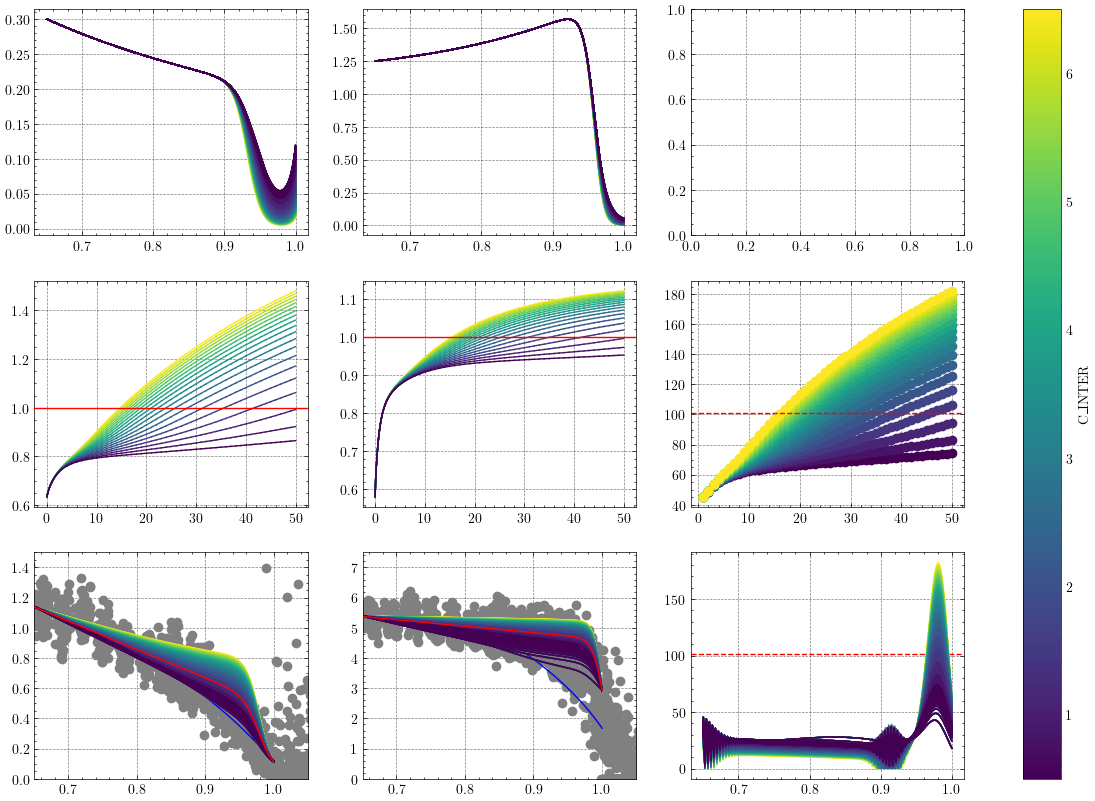

In [30]:
# colors = ['forestgreen', 'darkorange', 'royalblue']

fig, axs = plt.subplots(3,3, figsize=(15, 10))
for n, collected_data in enumerate(all_collections): 
    # color = colors[n]
    C_INTER = collected_data[0][0]
    color = plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter))
    for collect in collected_data: 
        C_INTER, inter_params, solutions_interelm_ne, solutions_interelm_te, _t_keep = collect
        
        axs[0,0].plot(phi_norm, inter_params.CHI / chi_gb[0], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)
        axs[0,1].plot(phi_norm, inter_params.D / Dbohm[0], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)

        axs[1, 0].plot(_t_keep*1000, solutions_interelm_te[ped_idx_te, :] / steady_state_te[ped_idx_te], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)
        axs[1, 1].plot(_t_keep*1000, solutions_interelm_ne[ped_idx_ne, :] / steady_state_ne[ped_idx_ne], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)

        axs[2, 0].plot(phi_norm, solutions_interelm_te[:, -1], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)
        axs[2, 1].plot(phi_norm, solutions_interelm_ne[:, -1], label=f"C_INTER={C_INTER}", color=color, zorder = (len(all_collections)+1) - n)

        _pressure = calculate_pressure(solutions_interelm_te, solutions_interelm_ne)
        grad_pressure = abs(np.gradient(_pressure, phi_norm, axis=0))
        
        axs[1, 2].scatter(_t_keep[-1]*1000, np.max(grad_pressure[:, -1]), color=color)
        axs[2, 2].plot(phi_norm, grad_pressure[:, -1], color=color, zorder = (len(all_collections)+1) - n)

max_grad_p_steady_state = np.max(abs(np.gradient(steady_state_pe, phi_norm)))
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), ax=axs, label='C_INTER')
axs[1, 2].axhline(max_grad_p_steady_state, color='red', linestyle='--', label='Steady state')
axs[2, 0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, label='Experimental data', color='grey')
axs[2, 1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, label='Experimental data', color='grey')
axs[2, 0].plot(phi_norm, post_elm_te, label='Post-ELM', color='blue')
axs[2, 2].axhline(max_grad_p_steady_state, color='red', linestyle='--', label='Steady state')
axs[2, 1].plot(phi_norm, post_elm_ne, label='Post-ELM', color='blue')
axs[2, 0].plot(phi_norm, steady_state_te, label='Steady state', color='red', zorder=50)
axs[2, 1].plot(phi_norm, steady_state_ne, label='Steady state', color='red', zorder=50)
axs[2, 0].set_xlim(phi_norm.min(), 1.05)
axs[2, 1].set_xlim(phi_norm.min(), 1.05)
axs[2, 0].set_ylim(0.0, 1.5)
axs[2, 1].set_ylim(0.0, 7.5)

axs[1, 0].axhline(1.0, color='red', zorder=50)
axs[1, 1].axhline(1.0, color='red', zorder=50)
# axs[1, 0].axhline(steady_state_te[ped_idx_te], color='red', linestyle='--', label='Steady state')
# axs[1, 1].axhline(steady_state_ne[ped_idx_ne], color='red', linestyle='--', label='Steady state')

# axs[0, 2].remove()

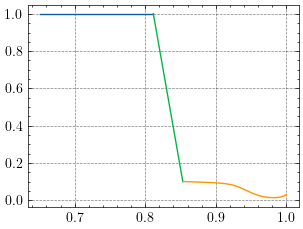

In [28]:
BASLINE_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = 1.0, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr, 
            mps=machineparams,
        )

# 
# chi_solution_inside = solve_ivp(
#     ode_system, 
#     [x_eval.min(), x_eval.max()],
#     [chi_gb[0]*2],
#     args = (p_chi, r_chi, {'params': BASLINE_PARAMS}, {'params': BASLINE_PARAMS}),
#     t_eval=x_eval, 
#     method='RK45')
# 
ped_bool = phi_norm > (te_fit_params.p - 4*te_fit_params.w)
x_eval   = phi_norm[~ped_bool]

chi_solution_core = np.ones_like(x_eval)*chi_gb[0]

plt.plot(x_eval, chi_solution_core / chi_gb[0])
ped_bool = np.logical_and(phi_norm > (te_fit_params.p - 4*te_fit_params.w), (phi_norm < te_fit_params.p - 3*te_fit_params.w))
x_eval   = phi_norm[ped_bool]

m = (chi_gb[0]/10.0 - chi_gb[0]) / (x_eval.max() - x_eval.min())
b = chi_gb[0] - m*(x_eval.min())

chi_solution_intermezzo = m*x_eval+b

# print(min(chi_solution_core) / chi_gb[0])
plt.plot(x_eval, chi_solution_intermezzo / chi_gb[0])

ped_bool = phi_norm > te_fit_params.p - 3*te_fit_params.w
x_eval   = phi_norm[ped_bool]
chi_solution_etb = solve_ivp(
    ode_system, 
    [x_eval.min(), x_eval.max()],
    [chi_solution_intermezzo[-1]],
    args = (p_chi, r_chi, {'params': BASLINE_PARAMS}, {'params': BASLINE_PARAMS}),
    t_eval=x_eval, 
    method='RK45')

plt.plot(x_eval, chi_solution_etb.y[0] / chi_gb[0])


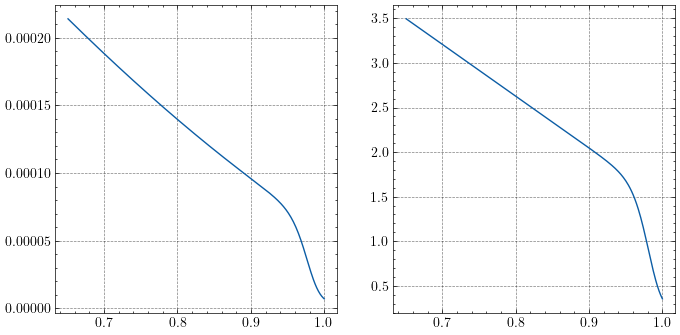

In [3]:

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(phi_norm, Dbohmgb)
axs[1].plot(phi_norm, Dbohm)

In [16]:
CHI0_INTRA = chi_gb[0]    
D0_INTRA   = Dbohm[0]

C_CRASH = 1.4558620689655173 # scan_crashes[best_c_crash_idx]
intra_params = TransParams(
        CHI=normal_distribution(phi_norm, te_fit_params.p - te_fit_params.w, te_fit_params.w*1.5, C_CRASH, CHI0_INTRA*2.0), # np.ones_like(phi_norm),
        D=normal_distribution(phi_norm, ne_fit_params.p - ne_fit_params.w, ne_fit_params.w*1.5, C_CRASH , D0_INTRA*5.0), # np.ones_like(phi_norm),
        V=np.ones_like(phi_norm),
        S_N=np.zeros_like(phi_norm),
        S_T=np.zeros_like(phi_norm),
        _C = C_CRASH,
        ne_fitparams=ne_fit_params, 
        te_fitparams=te_fit_params, 
        bcs=BCS.INTRA_FLUXIN, 
        dphi_normdr=dphi_normdr,
        mps = machineparams
    )

intra_params.heatfluxin   = phi_norm[0]*(chi_gb[0])*np.gradient(steady_state_te, phi_norm)[0]
intra_params.te_inner_lim = 0.0

intra_params.particlefluxin = (Dbohm[0])*np.gradient(steady_state_ne, phi_norm)[0]*dphi_normdr[0] + intra_params.V[0]*steady_state_ne[0]
intra_params.particlefluxout = (intra_params.D[-1])*np.gradient(steady_state_ne, phi_norm)[-1]*dphi_normdr[-1] + intra_params.V[-1]*steady_state_ne[-1]    
intra_params.ne_inner_lim = 0.0 # max(steady_state_ne) * scale_factor # scale_factor # (1.0/(C_CRASH*2))
intra_params.ne_outer_lim = 0.0 # steady_state_ne[-1] * scale_factor # (1.0/C_CRASH) # steady_state_ne[-1]*0.3

tau_intraelm = 200E-6 # 200 us
t_interval = [0, tau_intraelm]
t_keep     = np.linspace(0, tau_intraelm, 10)
solutions_intraelm_te = solve_pde(phi_norm, steady_state_te, t_interval, intra_params, T_model, t_keep)
solutions_intraelm_ne = solve_pde(phi_norm, steady_state_ne, t_interval, intra_params, n_model, t_keep)
solutions_intraelm_pe = calculate_pressure(solutions_intraelm_te, solutions_intraelm_ne)
post_elm_ne = solutions_intraelm_ne[:, -1]
post_elm_te = solutions_intraelm_te[:, -1]
post_elm_pe = solutions_intraelm_pe[:, -1]


In [13]:

max_c_inter = 0.21
min_c_inter = -0.1

tau_interelm = 0.05 # 
t_interval = [0, tau_interelm]
t_keep    = np.linspace(0, tau_interelm, 10)


BASLINE_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = 1.0, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr, 
            mps=machineparams,
        )
BASLINE_PARAMS.CHI = get_chi_inter_unscaled(phi_norm, chi_gb[0], steady_state_te, BASLINE_PARAMS)
BASLINE_PARAMS.D = get_d_inter_unscaled(phi_norm, Dbohm[0]/2.0, steady_state_ne, BASLINE_PARAMS)

collected_data = []
for C_INTER in np.linspace(min_c_inter, max_c_inter, 100):
    INTER_PARAMS = TransParams(
            CHI = np.empty_like(phi_norm),
            D   = np.empty_like(phi_norm),
            V   = phi_norm**5,
            S_N = np.zeros_like(phi_norm),
            S_T = np.zeros_like(phi_norm),
            _C  = C_INTER, 
            ne_fitparams=ne_fit_params, 
            te_fitparams=te_fit_params,
            bcs=BCS.INTER_FLUXIN, 
            dphi_normdr=dphi_normdr, 
            mps=machineparams,
        )

    INTER_PARAMS.CHI = get_chi_inter(phi_norm, chi_gb[0], steady_state_te, INTER_PARAMS)
    INTER_PARAMS.D = get_d_inter(phi_norm, Dbohm[0]/2.0, steady_state_ne, INTER_PARAMS)

    collect = (C_INTER, INTER_PARAMS) # , solutions_interelm_te, solutions_interelm_ne)
    collected_data.append(collect)

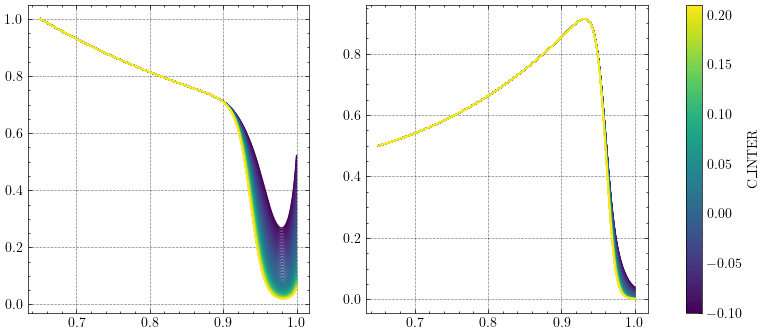

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for collect in collected_data: 
    C_INTER, INTER_PARAMS = collect 
    color = plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter))
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / chi_gb[0], color=color)
    axs[1].plot(phi_norm, INTER_PARAMS.D / Dbohm[0], color=color)
fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), ax=axs, label='C_INTER')

plt.show()

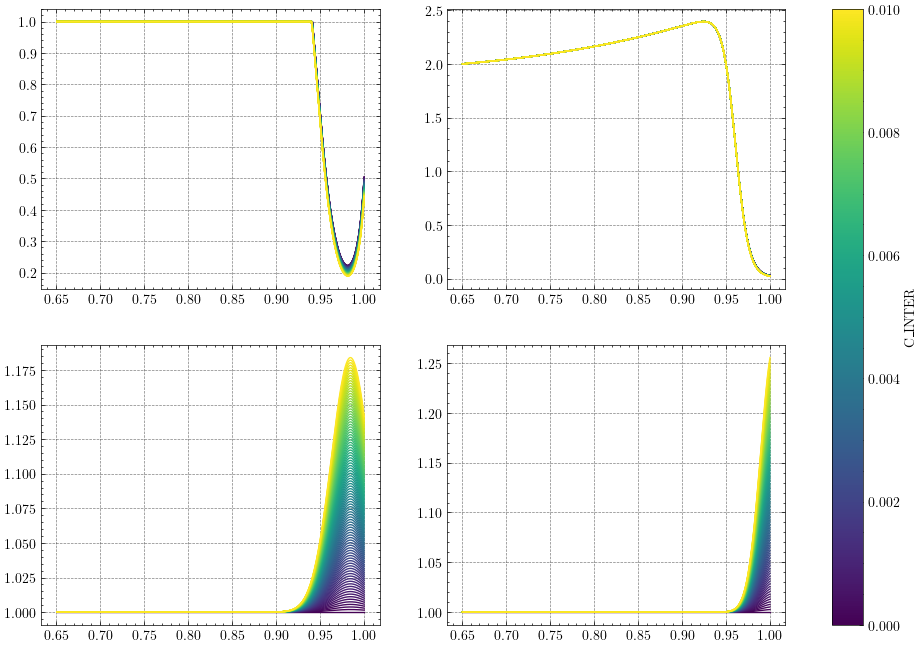

In [5]:
factor_ne = lambda phi_norm, c_scale: normal_distribution(phi_norm, INTER_PARAMS.ne_fitparams.p, INTER_PARAMS.ne_fitparams.w / 2.0, c_scale, 0.0) 
def factor_ne_full(phi_norm, c_scale): 
    fact_base = factor_ne(phi_norm, abs(c_scale))
    if c_scale < 0.0: 
        return 1.0 - fact_base
    else: 
        return 1.0 + fact_base


factor_te = lambda phi_norm, c_scale: normal_distribution(phi_norm, INTER_PARAMS.te_fitparams.p, INTER_PARAMS.te_fitparams.w / 2.0, c_scale, 0.0) 
def factor_te_full(phi_norm, c_scale):
    fact_base = factor_te(phi_norm, abs(c_scale))
    if c_scale < 0.0: 
        return 1.0 - fact_base
    else: 
        return 1.0 + fact_base
    
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()
for collect in collected_data: 
    C_INTER, INTER_PARAMS = collect
    color =  plt.cm.viridis((C_INTER - min_c_inter) / (max_c_inter - min_c_inter))  
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / chi_gb[0], color=color)
    # axs[0].plot(phi_norm, ((INTER_PARAMS.CHI / factor_te_full(phi_norm, C_INTER)) /  chi_gb[0]), color=color)
    axs[1].plot(phi_norm, (INTER_PARAMS.D / factor_ne_full(phi_norm, C_INTER)) / Dbohm[0], color=color)
    axs[2].plot(phi_norm, factor_te_full(phi_norm, C_INTER), color=color)
    axs[3].plot(phi_norm, factor_ne_full(phi_norm, C_INTER), color=color)

# axs[0].plot(phi_norm, BASLINE_PARAMS.CHI / chi_gb[0], color='black', ls='--')
# axs[1].plot(phi_norm, BASLINE_PARAMS.D / Dbohm[0], color='black', ls='--')

fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_c_inter, vmax=max_c_inter)), ax=axs, label="C_INTER")

plt.show()

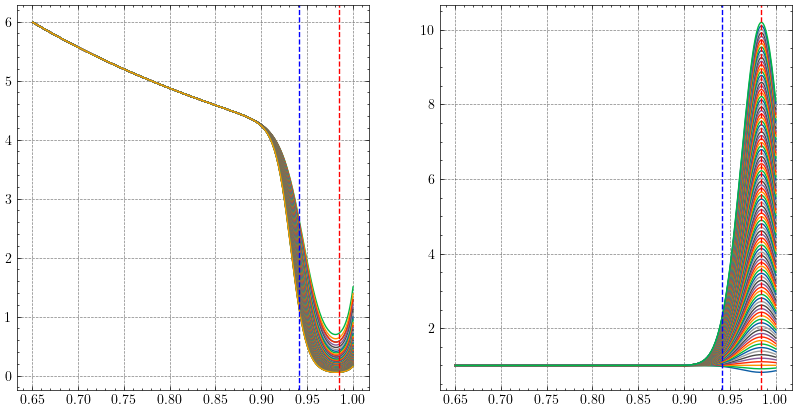

In [57]:
# Want to scale the CHI by a factor via INTER_PARAMS.CHI = get_chi_inter() / factor
# Where factor is 1.0 if phi <= te_fit_params.p - te_fit_params.w and a gaussian centeret at te_fit_params.p and scales with C_INTER
# 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(phi_norm, INTER_PARAMS.CHI)
c_scales = np.linspace(-0.01, 0.5, 100)
for c_scale in c_scales:
    factor = lambda phi_norm, c_scale: normal_distribution(phi_norm, te_fit_params.p, te_fit_params.w / 2.0, c_scale, 1.0) 
    
    axs[1].plot(phi_norm, factor(phi_norm, c_scale))
    axs[0].plot(phi_norm, INTER_PARAMS.CHI / factor(phi_norm, c_scale))


for ax in axs: 
    ax.axvline(te_fit_params.p, color='r', linestyle='--')
    ax.axvline(te_fit_params.p - te_fit_params.w, color='b', linestyle='--')
plt.show()

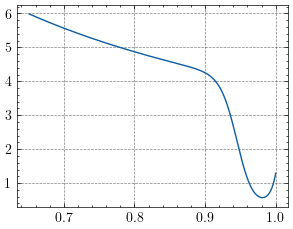

In [10]:
fig, axs = plt.subplots(1)


axs.plot(phi_norm, INTER_PARAMS.CHI)
plt.show()